In [1]:
# allows to import of modules
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
nb_dir
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [2]:
from metrics_acdc import load_nii, save_nii

In [3]:
import numpy as np
from PIL import Image


In [4]:
from pathlib import Path
Path.ls = lambda x: [i for i in x.iterdir()]

In [5]:
# Preprocess data

In [6]:
PATH = Path("/home/shaun/personal/acdc_challenge/data/")

In [7]:
pateints_path = (PATH/"test-raw").ls()

In [8]:
x = pateints_path[0]

In [9]:
name = x.stem

In [10]:
def get_info(patient_path):    
    cfg = {}
    with open(patient_path/"Info.cfg") as f:
        for line in f:
            key, val = line.strip().split(":")
            val = val.strip()
            if len(val) == 1:
                val = "0"+val 
            cfg[key] = val

    return cfg

In [11]:
    def process_niib(arr, size=None):
        frames_arr = []
        for i in range(arr.shape[-1]):
            frame = arr[:,:,i]
            if size:
                frame = np.array(Image.fromarray(frame).resize(size))[None] / 255
            frames_arr.append(frame)
        return torch.tensor(np.array(frames_arr))

In [12]:
from torch.utils.data import Dataset, DataLoader

In [13]:
import torch

In [14]:
import nibabel as nib

data -> inference
trans -> saving
shape -> reshapeing to save
header-> saving
file_path -> saving correct gt

In [15]:
class InferenceDS():
    def __init__(self, infolder, outfolder, size=256):
        self.pateints = list(infolder.iterdir())
        self.outfolder = outfolder
        self.size = (size, size)
        
    def __len__(self):
        return len(self.pateints)
    
    def build_dict(self, cfg, path, stage):
        file_path = path/"{}_frame{}.nii.gz".format(path.stem, cfg[stage])
        save_path = self.outfolder/"{}_{}.nii.gz".format(path.stem, stage)
        niib_np, trans, header = load_nii(str(file_path))
        imgs = process_niib(niib_np, self.size)
        
        return {
            "slices" : imgs,
            "transform": trans,
            "header": header,
            "org_shape": niib_np.shape,
            "save_path":save_path
        }
        
    
    def __getitem__(self,idx):
        patient_data = {}
        
        path = self.pateints[idx]
        cfg = get_info(path)
        
        data_ED = self.build_dict(cfg, path, "ED")
        data_ES = self.build_dict(cfg, path, "ES")
        
        patient_data["ED"] = data_ED
        patient_data["ES"] = data_ES
        
        return patient_data

In [16]:
pateint_ds = InferenceDS((PATH/"training-raw"),(PATH/"predictions"), size=256)


In [17]:
pateint_ds[0]["ED"].keys()

dict_keys(['slices', 'transform', 'header', 'org_shape', 'save_path'])

In [18]:
# pateint_ds = InferenceDS((PATH/"test-raw"), 256)
# p_loader = DataLoader(pateint_ds, batch_size=1,shuffle=False)

In [19]:
# Make Prediction

In [20]:
import model

In [21]:
PATH

PosixPath('/home/shaun/personal/acdc_challenge/data')

In [22]:
check_point = PATH/"model.pth"

In [23]:
unet = model.ResNetUNet(4)
unet.load_state_dict(torch.load(check_point))
unet.eval()
4

4

In [24]:
from tqdm import tqdm

In [28]:
i = 0

In [30]:
for pateint in pateint_ds:
#     pateint["ED"]["slices"]
    ed_data = pateint["ED"]["slices"]
    es_data = pateint["ES"]["slices"]
    print("ed:", ed_data.shape)
    print("es: ", es_data.shape)
    
    preds_ed = unet(ed_data)
    preds_sd = unet(es_data)
    process_preds(pateint, preds_ed, "ED")
    process_preds(pateint, preds_sd, "ES")
    
    
    

ed: torch.Size([9, 1, 256, 256])
es:  torch.Size([9, 1, 256, 256])
ed: torch.Size([17, 1, 256, 256])
es:  torch.Size([17, 1, 256, 256])
ed: torch.Size([12, 1, 256, 256])
es:  torch.Size([12, 1, 256, 256])
ed: torch.Size([11, 1, 256, 256])
es:  torch.Size([11, 1, 256, 256])


RuntimeError: Expected object of scalar type Double but got scalar type Float for argument #2 'weight'

In [84]:
final = np.argmax(preds_ed.detach().numpy(), axis=1)

In [46]:
import matplotlib.pyplot as plt

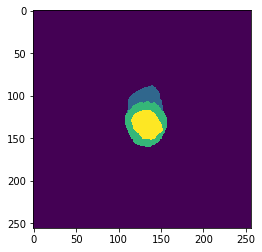

In [89]:
plt.imshow(final[4])

In [ ]:
# Save Predictions

In [90]:
import nibabel as nib


In [27]:
def process_preds(pateint, preds, stage):
    
    final = np.argmax(preds.detach().numpy(), axis=1)
    
    h,w,b = pateint[stage]["org_shape"]
    
    final_arr = []
    for im in final:
        x = np.array(Image.fromarray(im.astype(np.uint8)).resize((w,h)))
        final_arr.append(x)

    final_arr = np.array(final_arr)
    tmp = np.zeros(pateint["ED"]["org_shape"])
    for i in range(b):
        tmp[:,:,i] = final_arr[i]
    
#     f = final_arr.reshape(pateint[stage]["org_shape"])

    nimg = nib.Nifti1Image(tmp, affine=pateint[stage]["transform"], header=pateint[stage]["header"])
    nimg.to_filename(str(pateint[stage]["save_path"]))

In [40]:
final = np.argmax(preds_ed.detach().numpy(), axis=1)

In [60]:
h,w,b = pateint["ED"]["org_shape"]
    
final_arr = []
for im in final:
    x = np.array(Image.fromarray(im.astype(np.uint8)).resize((w,h)))
    final_arr.append(x)
final_arr =  np.array(final_arr)

In [61]:
final_arr.shape

(9, 256, 216)

In [62]:
reshpe = final_arr.reshape(pateint["ED"]["org_shape"])

In [68]:
tmp = np.zeros(pateint["ED"]["org_shape"])

In [70]:
for i in range(9):
    tmp[:,:,i] = final_arr[i]

In [71]:
tmp.shape

(256, 216, 9)

In [ ]:
reshpe = final_arr.reshape()

In [63]:
reshpe.shape

(256, 216, 9)

In [67]:
reshpe[:,:,5].shape

(256, 216)

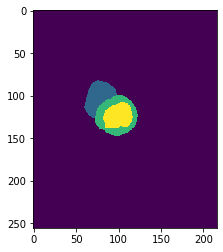

In [75]:
plt.imshow(tmp[:,:,3])